In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# **Experiment 1 - Process and Train Cats and Dogs Dataset**

In [ ]:
import os

num_skipped = 0
for folder_name in ("Cat", "Dog"):
    folder_path = os.path.join("drive/MyDrive/PetImages", folder_name)
    for fname in os.listdir(folder_path):
        fpath = os.path.join(folder_path, fname)
        try:
            fobj = open(fpath, "rb")
            is_jfif = tf.compat.as_bytes("JFIF") in fobj.peek(10)
        finally:
            fobj.close()

        if not is_jfif:
            num_skipped += 1
            # Delete corrupted image
            os.remove(fpath)

print("Deleted %d images" % num_skipped)

In [ ]:
import random
import glob
import shutil
import os

#os.mkdir("Reduced")
#os.chdir("Reduced")
#os.getcwd()

#os.mkdir('cat')
#os.mkdir('dog')
#os.chdir("..")


for c in random.sample(glob.glob('drive/MyDrive/PetImages/Cat/*.jpg'), 1250):
  shutil.move(c, "drive/MyDrive/Reduced/cat")

for c in random.sample(glob.glob('drive/MyDrive/PetImages/Dog/*.jpg'), 1250):
  shutil.move(c, "drive/MyDrive/Reduced/dog")



In [ ]:
image_size = (180, 180)
batch_size = 32

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "drive/MyDrive/Reduced",
    validation_split=0.2,
    subset="training",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
)
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "drive/MyDrive/Reduced",
    validation_split=0.2,
    subset="validation",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
)

Found 2500 files belonging to 2 classes.
Using 2000 files for training.
Found 2500 files belonging to 2 classes.
Using 500 files for validation.


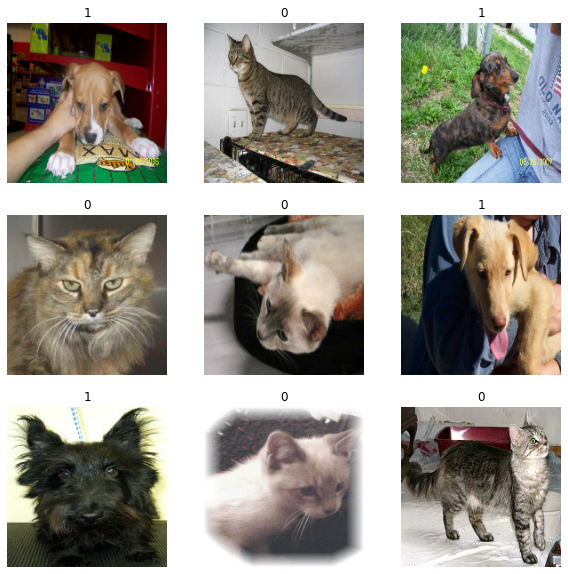

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(int(labels[i]))
        plt.axis("off")

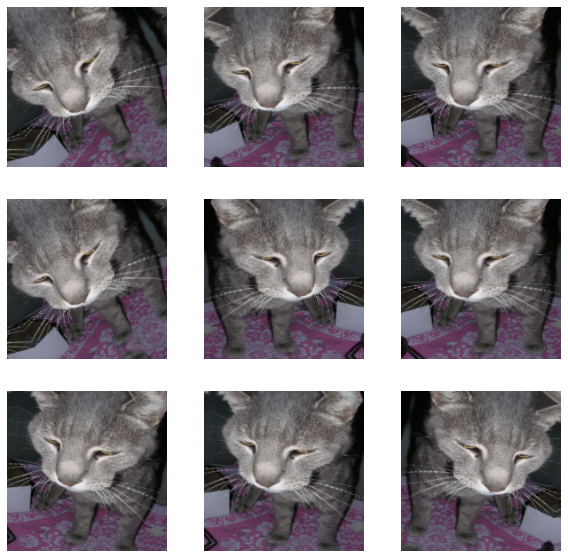

In [ ]:
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
    ]
)

plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")

In [ ]:
train_ds = train_ds.prefetch(buffer_size=32)
val_ds = val_ds.prefetch(buffer_size=32)

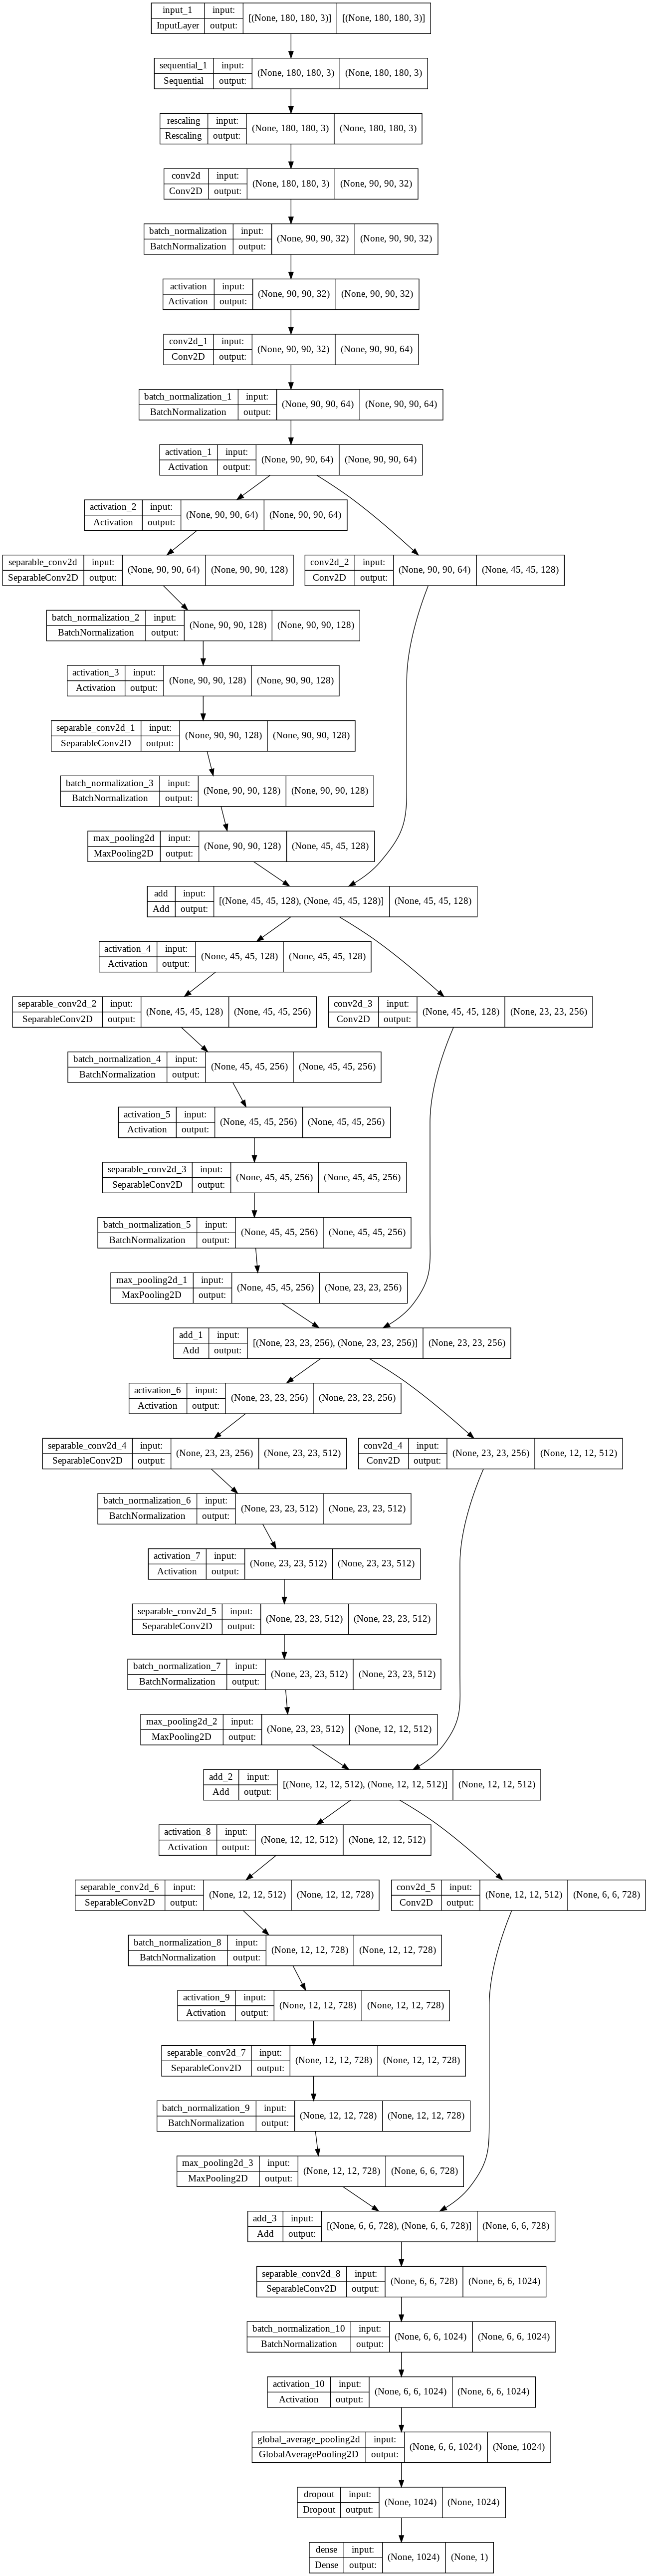

In [ ]:
def make_model(input_shape, num_classes):
    inputs = keras.Input(shape=input_shape)
    # Image augmentation block
    x = data_augmentation(inputs)

    # Entry block
    x = layers.Rescaling(1.0 / 255)(x)
    x = layers.Conv2D(32, 3, strides=2, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.Conv2D(64, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    previous_block_activation = x  # Set aside residual

    for size in [128, 256, 512, 728]:
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

        # Project residual
        residual = layers.Conv2D(size, 1, strides=2, padding="same")(
            previous_block_activation
        )
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    x = layers.SeparableConv2D(1024, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.GlobalAveragePooling2D()(x)
    if num_classes == 2:
        activation = "sigmoid"
        units = 1
    else:
        activation = "softmax"
        units = num_classes

    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(units, activation=activation)(x)
    return keras.Model(inputs, outputs)


model = make_model(input_shape=image_size + (3,), num_classes=2)
keras.utils.plot_model(model, show_shapes=True)

In [ ]:
epochs = 50

callbacks = [
    keras.callbacks.ModelCheckpoint("save_at_{epoch}.h5"),
]
model.compile(
    optimizer=keras.optimizers.Adam(1e-4),
    loss="binary_crossentropy",
    metrics=["accuracy"],
)
model.fit(
    train_ds, epochs=epochs, callbacks=callbacks, validation_data=val_ds,
)

Epoch 1/50
63/63 [==============================] - 212s 3s/step - loss: 0.6779 - accuracy: 0.6105 - val_loss: 0.6931 - val_accuracy: 0.5040
Epoch 2/50
63/63 [==============================] - 13s 198ms/step - loss: 0.6361 - accuracy: 0.6470 - val_loss: 0.6931 - val_accuracy: 0.5040
Epoch 3/50
63/63 [==============================] - 13s 199ms/step - loss: 0.6178 - accuracy: 0.6710 - val_loss: 0.6931 - val_accuracy: 0.5040
Epoch 4/50
63/63 [==============================] - 13s 198ms/step - loss: 0.6062 - accuracy: 0.6675 - val_loss: 0.6934 - val_accuracy: 0.5040
Epoch 5/50
63/63 [==============================] - 13s 198ms/step - loss: 0.5857 - accuracy: 0.6925 - val_loss: 0.6940 - val_accuracy: 0.5040
Epoch 6/50
63/63 [==============================] - 13s 199ms/step - loss: 0.5501 - accuracy: 0.7150 - val_loss: 0.6924 - val_accuracy: 0.5060
Epoch 7/50
63/63 [==============================] - 13s 199ms/step - loss: 0.5592 - accuracy: 0.7160 - val_loss: 0.6849 - val_accuracy: 0.5540
E

# **Experiment 1 - Process and Train Stanford Dogs Dataset**

In [ ]:
image_size = (180, 180)
batch_size = 32

train_ds_2 = tf.keras.preprocessing.image_dataset_from_directory(
    "drive/MyDrive/Images",
    validation_split=0.2,
    subset="training",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
)
val_ds_2 = tf.keras.preprocessing.image_dataset_from_directory(
    "drive/MyDrive/Images",
    validation_split=0.2,
    subset="validation",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
)

Found 2110 files belonging to 120 classes.
Using 1688 files for training.
Found 2110 files belonging to 120 classes.
Using 422 files for validation.


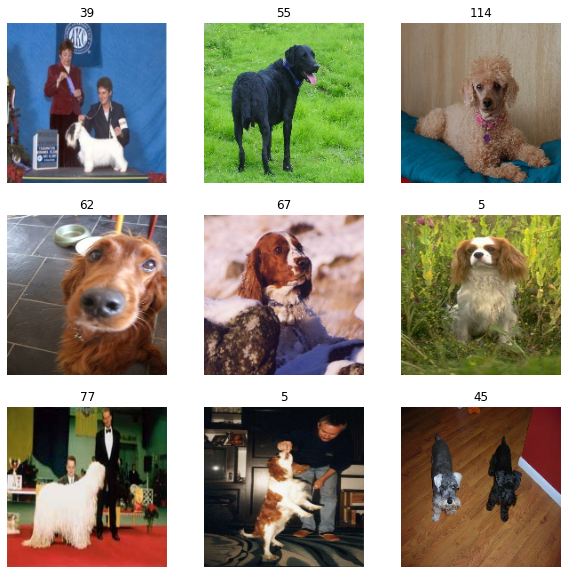

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds_2.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(int(labels[i]))
        plt.axis("off")

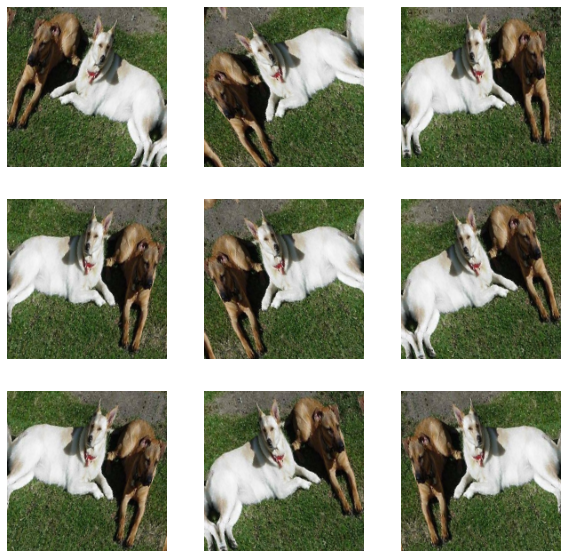

In [ ]:
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
    ]
)

plt.figure(figsize=(10, 10))
for images, _ in train_ds_2.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")

In [ ]:
train_ds_2 = train_ds_2.prefetch(buffer_size=32)
val_ds_2 = val_ds_2.prefetch(buffer_size=32)

In [ ]:
epochs = 50

callbacks = [
    keras.callbacks.ModelCheckpoint("save_at_{epoch}.h5"),
]
model.compile(
    optimizer=keras.optimizers.Adam(1e-4),
    loss="binary_crossentropy",
    metrics=["accuracy"],
)
model.fit(
    train_ds_2, epochs=epochs, callbacks=callbacks, validation_data=val_ds_2,
)

Epoch 1/50
53/53 [==============================] - 175s 3s/step - loss: -133.0519 - accuracy: 0.0101 - val_loss: -24.9717 - val_accuracy: 0.0047
Epoch 2/50
53/53 [==============================] - 15s 274ms/step - loss: -367.0467 - accuracy: 0.0101 - val_loss: -105.4779 - val_accuracy: 0.0047
Epoch 3/50
53/53 [==============================] - 15s 281ms/step - loss: -579.3807 - accuracy: 0.0101 - val_loss: -242.8793 - val_accuracy: 0.0047
Epoch 4/50
53/53 [==============================] - 15s 279ms/step - loss: -756.0315 - accuracy: 0.0101 - val_loss: -407.4518 - val_accuracy: 0.0047
Epoch 5/50
53/53 [==============================] - 15s 272ms/step - loss: -914.4376 - accuracy: 0.0101 - val_loss: -569.4941 - val_accuracy: 0.0047
Epoch 6/50
53/53 [==============================] - 15s 273ms/step - loss: -1065.9303 - accuracy: 0.0101 - val_loss: -703.9644 - val_accuracy: 0.0047
Epoch 7/50
53/53 [==============================] - 15s 278ms/step - loss: -1214.2465 - accuracy: 0.0101 - v

# **Experiment 1 - Save the Trained Model**

In [ ]:
model.save("model.h5")

model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)

In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 180, 180, 3  0           []                               
                                )]                                                                
                                                                                                  
 sequential_1 (Sequential)      (None, 180, 180, 3)  0           ['input_1[0][0]']                
                                                                                                  
 rescaling (Rescaling)          (None, 180, 180, 3)  0           ['sequential_1[0][0]']           
                                                                                                  
 conv2d (Conv2D)                (None, 90, 90, 32)   896         ['rescaling[0][0]']          

# **Experiment 2 - Train Cats and Dogs Dataset with New Output Layer**

In [ ]:
from keras.models import load_model
modify_model = load_model("model.h5")

from keras.models import Model

modify_model = Model(inputs=modify_model.input, outputs=modify_model.get_layer(index=49).output)
x = modify_model.output
predictions = layers.Dense(1, activation='sigmoid', name='new_output')(x)
model_2 = Model(inputs=modify_model.input, outputs=predictions)



In [ ]:
epochs = 50

callbacks_2 = [
    keras.callbacks.ModelCheckpoint("model2_save_at_{epoch}.h5"),
]
model_2.compile(
    optimizer=keras.optimizers.Adam(1e-4),
    loss="binary_crossentropy",
    metrics=["accuracy"],
)
model_2.fit(
    train_ds, epochs=epochs, callbacks=callbacks, validation_data=val_ds,
)

Epoch 1/50
63/63 [==============================] - 15s 206ms/step - loss: 0.3926 - accuracy: 0.8085 - val_loss: 0.5042 - val_accuracy: 0.7880
Epoch 2/50
63/63 [==============================] - 13s 201ms/step - loss: 0.1994 - accuracy: 0.9210 - val_loss: 0.7692 - val_accuracy: 0.7680
Epoch 3/50
63/63 [==============================] - 13s 201ms/step - loss: 0.1896 - accuracy: 0.9195 - val_loss: 0.5514 - val_accuracy: 0.8000
Epoch 4/50
63/63 [==============================] - 13s 200ms/step - loss: 0.1720 - accuracy: 0.9385 - val_loss: 0.5324 - val_accuracy: 0.8060
Epoch 5/50
63/63 [==============================] - 13s 201ms/step - loss: 0.1345 - accuracy: 0.9500 - val_loss: 0.5385 - val_accuracy: 0.8060
Epoch 6/50
63/63 [==============================] - 13s 201ms/step - loss: 0.1337 - accuracy: 0.9535 - val_loss: 0.5748 - val_accuracy: 0.7760
Epoch 7/50
63/63 [==============================] - 13s 203ms/step - loss: 0.1332 - accuracy: 0.9440 - val_loss: 0.6448 - val_accuracy: 0.7840

In [ ]:
model_2.save("model_2.h5")

In [ ]:
print("Evaluate")
result = model.evaluate(val_ds)

Evaluate
16/16 [==============================] - 1s 46ms/step - loss: 0.6759 - accuracy: 0.7860


# **Experiment 3 - Train Cats and Dogs Dataset with New 1st, 2nd Convolutional Layer and Output Layer**

In [ ]:
from keras.models import load_model
model_3 = load_model("model_2.h5")

model_new = make_model(input_shape=image_size + (3,), num_classes=2)

model_new.summary()

Model: "model_10"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_9 (InputLayer)           [(None, 180, 180, 3  0           []                               
                                )]                                                                
                                                                                                  
 sequential_1 (Sequential)      (None, 180, 180, 3)  0           ['input_9[0][0]']                
                                                                                                  
 rescaling_8 (Rescaling)        (None, 180, 180, 3)  0           ['sequential_1[8][0]']           
                                                                                                  
 conv2d_48 (Conv2D)             (None, 90, 90, 32)   896         ['rescaling_8[0][0]']     

In [ ]:
l1 = model_3.get_layer("conv2d")
l1.set_weights(model_new.get_layer("conv2d_48").get_weights())
l2 = model_3.get_layer("conv2d_1")
l2.set_weights(model_new.get_layer("conv2d_49").get_weights())



In [ ]:
epochs = 50

callbacks = [
    keras.callbacks.ModelCheckpoint("Model3_save_at_{epoch}.h5"),
]
model_3.compile(
    optimizer=keras.optimizers.Adam(1e-4),
    loss="binary_crossentropy",
    metrics=["accuracy"],
)
model_3.fit(
    train_ds, epochs=epochs, callbacks=callbacks, validation_data=val_ds,
)

Epoch 1/50
63/63 [==============================] - 15s 205ms/step - loss: 0.8630 - accuracy: 0.6870 - val_loss: 1.2142 - val_accuracy: 0.5760
Epoch 2/50
63/63 [==============================] - 13s 199ms/step - loss: 0.5126 - accuracy: 0.7680 - val_loss: 0.7383 - val_accuracy: 0.6340
Epoch 3/50
63/63 [==============================] - 13s 200ms/step - loss: 0.4417 - accuracy: 0.7970 - val_loss: 0.6586 - val_accuracy: 0.6980
Epoch 4/50
63/63 [==============================] - 13s 201ms/step - loss: 0.4147 - accuracy: 0.8130 - val_loss: 0.6733 - val_accuracy: 0.7160
Epoch 5/50
63/63 [==============================] - 13s 201ms/step - loss: 0.3649 - accuracy: 0.8425 - val_loss: 0.5882 - val_accuracy: 0.7240
Epoch 6/50
63/63 [==============================] - 13s 201ms/step - loss: 0.3692 - accuracy: 0.8410 - val_loss: 0.5096 - val_accuracy: 0.7640
Epoch 7/50
63/63 [==============================] - 13s 200ms/step - loss: 0.3337 - accuracy: 0.8510 - val_loss: 0.5348 - val_accuracy: 0.7660

In [ ]:
print("Evaluate")
result = model_3.evaluate(val_ds)

Evaluate
16/16 [==============================] - 1s 47ms/step - loss: 0.6095 - accuracy: 0.8060


# **Experiment 4 - Train Cats and Dogs Dataset with New Last 1st, 2nd Convolutional Layer and Output Layer**

In [32]:
from keras.models import load_model
model_4 = load_model("model_2.h5")

model_new = make_model(input_shape=image_size + (3,), num_classes=2)

model_new.summary()

Model: "model_12"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_11 (InputLayer)          [(None, 180, 180, 3  0           []                               
                                )]                                                                
                                                                                                  
 sequential_1 (Sequential)      (None, 180, 180, 3)  0           ['input_11[0][0]']               
                                                                                                  
 rescaling_10 (Rescaling)       (None, 180, 180, 3)  0           ['sequential_1[10][0]']          
                                                                                                  
 conv2d_60 (Conv2D)             (None, 90, 90, 32)   896         ['rescaling_10[0][0]']    

In [33]:
l1 = model_4.get_layer("conv2d_4")
l1.set_weights(model_new.get_layer("conv2d_64").get_weights())
l2 = model_4.get_layer("conv2d_5")
l2.set_weights(model_new.get_layer("conv2d_65").get_weights())

In [34]:
epochs = 50

callbacks = [
    keras.callbacks.ModelCheckpoint("Model4_save_at_{epoch}.h5"),
]
model_4.compile(
    optimizer=keras.optimizers.Adam(1e-4),
    loss="binary_crossentropy",
    metrics=["accuracy"],
)
model_4.fit(
    train_ds, epochs=epochs, callbacks=callbacks, validation_data=val_ds,
)

Epoch 1/50
63/63 [==============================] - 15s 206ms/step - loss: 0.2081 - accuracy: 0.9260 - val_loss: 0.7678 - val_accuracy: 0.7880
Epoch 2/50
63/63 [==============================] - 14s 212ms/step - loss: 0.1123 - accuracy: 0.9625 - val_loss: 0.6332 - val_accuracy: 0.7980
Epoch 3/50
63/63 [==============================] - 13s 201ms/step - loss: 0.0906 - accuracy: 0.9670 - val_loss: 1.1428 - val_accuracy: 0.7460
Epoch 4/50
63/63 [==============================] - 13s 201ms/step - loss: 0.0870 - accuracy: 0.9675 - val_loss: 0.5445 - val_accuracy: 0.8400
Epoch 5/50
63/63 [==============================] - 13s 201ms/step - loss: 0.0787 - accuracy: 0.9680 - val_loss: 1.7592 - val_accuracy: 0.6860
Epoch 6/50
63/63 [==============================] - 13s 201ms/step - loss: 0.0843 - accuracy: 0.9635 - val_loss: 0.9707 - val_accuracy: 0.7860
Epoch 7/50
63/63 [==============================] - 13s 200ms/step - loss: 0.0864 - accuracy: 0.9660 - val_loss: 1.1681 - val_accuracy: 0.7620

In [35]:
print("Evaluate")
result = model_4.evaluate(val_ds)

Evaluate
16/16 [==============================] - 1s 48ms/step - loss: 0.6914 - accuracy: 0.8420
